In [1]:
using MomentClosure, DiffEqJump, DiffEqBase, OrdinaryDiffEq, DiffEqBase.EnsembleAnalysis, Plots, Latexify

┌ Info: Precompiling MomentClosure [01a1b25a-ecf0-48c5-ae58-55bfd5393600]
└ @ Base loading.jl:1423


In [2]:
@parameters t, k_on, k_off, k_p, γ_p, b
@variables g(t), p(t)

# species
vars   = [g, p]

# parameters
ps = [k_on, k_off, k_p, γ_p, b]

# net stoichiometry matrix
# symbolic parameter in the matrix, `b`, denotes that the corresponding 
# reaction product is sampled from the geometric distribution with mean b
S_mat = [1 -1 0 0;
         0 0 b -1]

# propensity functions
as = [k_on*(1-g),    # G* -> G
      k_off*g*(p^2), # G + 2P -> G*
      k_p*g,         # G -> G + mP, m ~ Geometric(mean=b)
      γ_p*p]         # P -> ∅

binary_vars = [1]

rn = ReactionSystemMod(t, vars, ps, as, S_mat);

ReactionSystemMod(t, SymbolicUtils.Term{Real, Base.ImmutableDict{DataType, Any}}[g(t), p(t)], SymbolicUtils.Sym{Real, Base.ImmutableDict{DataType, Any}}[k_on, k_off, k_p, γ_p, b], SymbolicUtils.Mul{Real, Int64, Dict{Any, Number}, Nothing}[k_on*(1 - g(t)), k_off*(p(t)^2)*g(t), k_p*g(t), γ_p*p(t)], Any[1 -1 0 0; 0 0 b -1], Symbol("##ReactionSystemMod#291"))

In [3]:
# PARAMETER INITIALISATION
mean_p = 200
mean_b = 70
γ_p_val = 1
k_off_val = 0.001
k_on_val = 0.05

k_p_val = mean_p * γ_p_val * (k_off_val * mean_p^2 + k_on_val) / (k_on_val * mean_b)

pmap = [k_on => k_on_val,
        k_off => k_off_val,
        k_p => k_p_val,
        γ_p => γ_p_val,
        b => mean_b]

u₀ = [1, 1]

tspan = (0., 6.0);

(0.0, 6.0)

In [4]:
# PARAMETER INITIALISATION
mean_p = 200
mean_b = 70
γ_p_val = 1
k_off_val = 0.001
k_on_val = 0.05

k_p_val = mean_p * γ_p_val * (k_off_val * mean_p^2 + k_on_val) / (k_on_val * mean_b);

2288.5714285714284

In [5]:
# create a discrete problem setting the simulation parameters
dprob = DiscreteProblem(u₀, tspan, pmap)

# create a JumpProblem compatible with ReactionSystemMod
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false, false))

# simulate 2×10⁴ SSA trajectories
ensembleprob  = EnsembleProblem(jprob)
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=0.1, trajectories=20000)
# compute the means and variances
means_ssa, vars_ssa = timeseries_steps_meanvar(sol_SSA);

 20.147313 seconds (156.59 M allocations: 7.793 GiB, 27.97% gc time, 16.73% compilation time)


(RecursiveArrayTools.DiffEqArray{Float64, 2, Vector{Vector{Float64}}, Vector{Float64}, Nothing, Nothing, Nothing, Nothing}([[1.0, 1.0], [9.999999999999925e-5, 673.3061000000002], [0.0, 610.3742500000029], [0.00015000000000000056, 553.8630000000062], [9.999999999999929e-5, 502.85175000000015], [4.999999999999967e-5, 456.1208999999993], [9.999999999999937e-5, 414.4649499999997], [0.00019999999999999833, 376.4994500000006], [5.000000000000003e-5, 342.5893000000019], [0.0, 311.7909]  …  [9.99999999999995e-5, 38.19615000000031], [0.0003, 37.63165000000003], [0.00014999999999999996, 38.047000000000125], [9.999999999999948e-5, 38.11414999999984], [0.00020000000000000025, 37.843049999999764], [9.999999999999942e-5, 38.09855000000004], [0.00014999999999999982, 37.87685000000021], [0.0002499999999999989, 38.125749999999854], [0.00039999999999999975, 38.24700000000007], [9.999999999999965e-5, 37.596700000000055]], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  5.1, 5.2, 5.3, 5.4, 5.5, 5.6,

In [6]:
eqs = generate_raw_moment_eqs(rn, 3)
latexify(eqs)

"\\begin{align*}\n\\frac{d\\mu{_{10}}}{dt} =& k_{on} - k_{on} \\mu{_{10}} - k_{off} \\mu{_{12}} \\\\\n\\frac{d\\mu{_{01}}}{dt} =& b k_{p} \\mu{_{10}} - \\gamma_{p} \\mu{_{01}} \\\\\n\\frac{d\\mu{_{20}}}{dt} =& k_{on} + k_{on} \\mu{_{10}} + k_{off} \\mu{_{12}} - 2 k_{on} \\mu{_{20}} - 2 k_{off}" ⋯ 821 bytes ⋯ "{12}} \\\\\n\\frac{d\\mu{_{03}}}{dt} =& b k_{p} \\mu{_{10}} + 3 \\gamma_{p} \\mu{_{02}} + 6 k_{p} b^{2} \\mu{_{10}} + 6 k_{p} b^{3} \\mu{_{10}} + 3 b k_{p} \\mu{_{11}} + 3 b k_{p} \\mu{_{12}} + 6 k_{p} b^{2} \\mu{_{11}} - \\gamma_{p} \\mu{_{01}} - 3 \\gamma_{p} \\mu{_{03}}\n\\end{align*}\n"

In [7]:
println(latexify(eqs))

\begin{align*}
\frac{d\mu{_{10}}}{dt} =& k_{on} - k_{on} \mu{_{10}} - k_{off} \mu{_{12}} \\
\frac{d\mu{_{01}}}{dt} =& b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}} \\
\frac{d\mu{_{20}}}{dt} =& k_{on} + k_{on} \mu{_{10}} + k_{off} \mu{_{12}} - 2 k_{on} \mu{_{20}} - 2 k_{off} \mu{_{22}} \\
\frac{d\mu{_{11}}}{dt} =& k_{on} \mu{_{01}} + b k_{p} \mu{_{20}} - k_{off} \mu{_{13}} - k_{on} \mu{_{11}} - \gamma_{p} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 k_{p} b^{2} \mu{_{10}} + 2 b k_{p} \mu{_{11}} - 2 \gamma_{p} \mu{_{02}} \\
\frac{d\mu{_{30}}}{dt} =& k_{on} + 2 k_{on} \mu{_{10}} + 3 k_{off} \mu{_{22}} - k_{off} \mu{_{12}} - 3 k_{on} \mu{_{30}} - 3 k_{off} \mu{_{32}} \\
\frac{d\mu{_{21}}}{dt} =& k_{off} \mu{_{13}} + k_{on} \mu{_{01}} + k_{on} \mu{_{11}} + b k_{p} \mu{_{30}} - 2 k_{off} \mu{_{23}} - \gamma_{p} \mu{_{21}} - 2 k_{on} \mu{_{21}} \\
\frac{d\mu{_{12}}}{dt} =& k_{on} \mu{_{02}} + \gamma_{p} \mu{_{11}} + b k_{p} \mu{_{20}} + 2 b k_{p} \mu{_{2

In [8]:
# specify the indices of species which molecule numbers are binary
binary_vars = [1]
# simplify the moment equations using properties of Bernoulli variables
clean_eqs = bernoulli_moment_eqs(eqs, binary_vars)
latexify(clean_eqs)

"\\begin{align*}\n\\frac{d\\mu{_{10}}}{dt} =& k_{on} - k_{on} \\mu{_{10}} - k_{off} \\mu{_{12}} \\\\\n\\frac{d\\mu{_{01}}}{dt} =& b k_{p} \\mu{_{10}} - \\gamma_{p} \\mu{_{01}} \\\\\n\\frac{d\\mu{_{11}}}{dt} =& k_{on} \\mu{_{01}} + b k_{p} \\mu{_{10}} - k_{off} \\mu{_{13}} - k_{on} \\mu{_{11}} -" ⋯ 374 bytes ⋯ "{12}} \\\\\n\\frac{d\\mu{_{03}}}{dt} =& b k_{p} \\mu{_{10}} + 3 \\gamma_{p} \\mu{_{02}} + 6 k_{p} b^{2} \\mu{_{10}} + 6 k_{p} b^{3} \\mu{_{10}} + 3 b k_{p} \\mu{_{11}} + 3 b k_{p} \\mu{_{12}} + 6 k_{p} b^{2} \\mu{_{11}} - \\gamma_{p} \\mu{_{01}} - 3 \\gamma_{p} \\mu{_{03}}\n\\end{align*}\n"

In [9]:
println(latexify(clean_eqs))

\begin{align*}
\frac{d\mu{_{10}}}{dt} =& k_{on} - k_{on} \mu{_{10}} - k_{off} \mu{_{12}} \\
\frac{d\mu{_{01}}}{dt} =& b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}} \\
\frac{d\mu{_{11}}}{dt} =& k_{on} \mu{_{01}} + b k_{p} \mu{_{10}} - k_{off} \mu{_{13}} - k_{on} \mu{_{11}} - \gamma_{p} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 k_{p} b^{2} \mu{_{10}} + 2 b k_{p} \mu{_{11}} - 2 \gamma_{p} \mu{_{02}} \\
\frac{d\mu{_{12}}}{dt} =& k_{on} \mu{_{02}} + \gamma_{p} \mu{_{11}} + b k_{p} \mu{_{10}} + 2 k_{p} b^{2} \mu{_{10}} + 2 b k_{p} \mu{_{11}} - k_{off} \mu{_{14}} - k_{on} \mu{_{12}} - 2 \gamma_{p} \mu{_{12}} \\
\frac{d\mu{_{03}}}{dt} =& b k_{p} \mu{_{10}} + 3 \gamma_{p} \mu{_{02}} + 6 k_{p} b^{2} \mu{_{10}} + 6 k_{p} b^{3} \mu{_{10}} + 3 b k_{p} \mu{_{11}} + 3 b k_{p} \mu{_{12}} + 6 k_{p} b^{2} \mu{_{11}} - \gamma_{p} \mu{_{01}} - 3 \gamma_{p} \mu{_{03}}
\end{align*}



In [10]:
normal_eqs = moment_closure(eqs, "normal", binary_vars)
latexify(normal_eqs, :closure)

"\\begin{align*}\n\\mu{_{13}} =& \\mu{_{03}} \\mu{_{10}} + 3 \\mu{_{01}} \\mu{_{12}} + 6 \\mu{_{01}}^{3} \\mu{_{10}} + 3 \\mu{_{02}} \\mu{_{11}} - 6 \\mu{_{01}}^{2} \\mu{_{11}} - 6 \\mu{_{01}} \\mu{_{02}} \\mu{_{10}} \\\\\n\\mu{_{14}} =& \\mu{_{04}} \\mu{_{10}} + 4 \\mu{_{03}} \\mu{_{11}} + 6 \\m" ⋯ 28 bytes ⋯ "{_{01}}^{3} \\mu{_{11}} + 4 \\mu{_{01}} \\mu{_{13}} + 36 \\mu{_{01}}^{2} \\mu{_{02}} \\mu{_{10}} - 24 \\mu{_{01}}^{4} \\mu{_{10}} - 6 \\mu{_{02}}^{2} \\mu{_{10}} - 12 \\mu{_{01}}^{2} \\mu{_{12}} - 24 \\mu{_{01}} \\mu{_{02}} \\mu{_{11}} - 8 \\mu{_{01}} \\mu{_{03}} \\mu{_{10}}\n\\end{align*}\n"

In [11]:
println(latexify(normal_eqs, :closure))

\begin{align*}
\mu{_{13}} =& \mu{_{03}} \mu{_{10}} + 3 \mu{_{01}} \mu{_{12}} + 6 \mu{_{01}}^{3} \mu{_{10}} + 3 \mu{_{02}} \mu{_{11}} - 6 \mu{_{01}}^{2} \mu{_{11}} - 6 \mu{_{01}} \mu{_{02}} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{04}} \mu{_{10}} + 4 \mu{_{03}} \mu{_{11}} + 6 \mu{_{02}} \mu{_{12}} + 24 \mu{_{01}}^{3} \mu{_{11}} + 4 \mu{_{01}} \mu{_{13}} + 36 \mu{_{01}}^{2} \mu{_{02}} \mu{_{10}} - 24 \mu{_{01}}^{4} \mu{_{10}} - 6 \mu{_{02}}^{2} \mu{_{10}} - 12 \mu{_{01}}^{2} \mu{_{12}} - 24 \mu{_{01}} \mu{_{02}} \mu{_{11}} - 8 \mu{_{01}} \mu{_{03}} \mu{_{10}}
\end{align*}



In [12]:
dm_eqs = moment_closure(eqs, "derivative matching", binary_vars)
latexify(dm_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& \mu{_{01}}^{3} \mu{_{02}}^{-3} \mu{_{11}}^{-3} \mu{_{12}}^{3} \mu{_{03}} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{01}}^{-4} \mu{_{02}}^{6} \mu{_{03}}^{-4} \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4} \mu{_{04}}
\end{align*}
"

In [13]:
println(latexify(dm_eqs, :closure))

\begin{align*}
\mu{_{13}} =& \mu{_{01}}^{3} \mu{_{02}}^{-3} \mu{_{11}}^{-3} \mu{_{12}}^{3} \mu{_{03}} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{01}}^{-4} \mu{_{02}}^{6} \mu{_{03}}^{-4} \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4} \mu{_{04}}
\end{align*}



In [14]:
cond_gaussian_eqs = moment_closure(eqs, "conditional gaussian", binary_vars)
latexify(cond_gaussian_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& 3 \mu{_{10}}^{-1} \mu{_{11}} \mu{_{12}} - 2 \mu{_{10}}^{-2} \mu{_{11}}^{3} \\
\mu{_{14}} =& 3 \mu{_{10}}^{-1} \mu{_{12}}^{2} + 6 \mu{_{10}}^{-3} \mu{_{11}}^{4} + 4 \mu{_{10}}^{-1} \mu{_{11}} \mu{_{13}} - 12 \mu{_{10}}^{-2} \mu{_{11}}^{2} \mu{_{12}}
\end{align*}
"

In [15]:
println(latexify(cond_gaussian_eqs, :closure))

\begin{align*}
\mu{_{13}} =& 3 \mu{_{10}}^{-1} \mu{_{11}} \mu{_{12}} - 2 \mu{_{10}}^{-2} \mu{_{11}}^{3} \\
\mu{_{14}} =& 3 \mu{_{10}}^{-1} \mu{_{12}}^{2} + 6 \mu{_{10}}^{-3} \mu{_{11}}^{4} + 4 \mu{_{10}}^{-1} \mu{_{11}} \mu{_{13}} - 12 \mu{_{10}}^{-2} \mu{_{11}}^{2} \mu{_{12}}
\end{align*}



In [16]:
cond_dm_eqs = moment_closure(eqs, "conditional derivative matching", binary_vars)
latexify(cond_dm_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& \mu{_{11}}^{-3} \mu{_{12}}^{3} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4}
\end{align*}
"

In [17]:
println(latexify(dm_eqs, :closure))

\begin{align*}
\mu{_{13}} =& \mu{_{01}}^{3} \mu{_{02}}^{-3} \mu{_{11}}^{-3} \mu{_{12}}^{3} \mu{_{03}} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{01}}^{-4} \mu{_{02}}^{6} \mu{_{03}}^{-4} \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4} \mu{_{04}}
\end{align*}



In [18]:
dm_eqs.odes.states

SymbolicUtils.Term{Real, Base.ImmutableDict{DataType, Any}}[μ₁₀(t), μ₀₁(t), μ₁₁(t), μ₀₂(t), μ₁₂(t), μ₀₃(t)][Base.OneTo(6)]

In [19]:
plt_m = plot()   # plot mean protein number
plt_std = plot() # plot ssd of protein number

# construct the initial molecule number mapping
u₀map = deterministic_IC(u₀, dm_eqs)

# solve moment ODEs for each closure and plot the results
for closure in ["normal", "derivative matching", 
                "conditional gaussian", "conditional derivative matching"]
    
    # it is very quick so we just apply all closures again
    closed_eqs = moment_closure(eqs, closure, binary_vars)
    
    # solve the system of moment ODEs
    oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
    sol = solve(oprob, AutoTsit5(Rosenbrock23()), saveat=0.01)
    
    # μ₀₁ is 2nd and μ₀₂ is 4th element in sol
    plt_m = plot!(plt_m, sol, vars=(0, 2), label=closure)
    plt_std = plot!(plt_std, sol.t, sqrt.(sol[4, :] .- sol[2, :].^2), label=closure)
    
end

plt_m = plot!(plt_m, xlabel="Time [hr]", ylabel="Protein mean level")
plt_m = plot!(plt_m, means_ssa.t, means_ssa[2,:], label="SSA", linestyle=:dash, color="gray")
plt_std = plot!(plt_std, xlabel="Time [hr]", ylabel="Protein standard deviation")
plt_std = plot!(plt_std, vars_ssa.t, sqrt.(vars_ssa[2,:]), label="SSA", linestyle=:dash, color="gray");

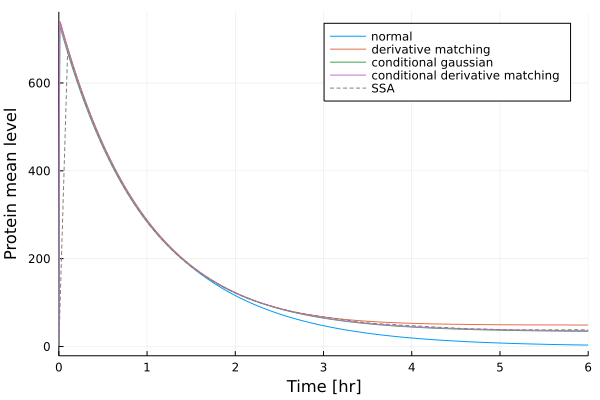

In [20]:
plot(plt_m, lw=2)

In [21]:
#savefig("../docs/src/assets/gene_1_means.svg")

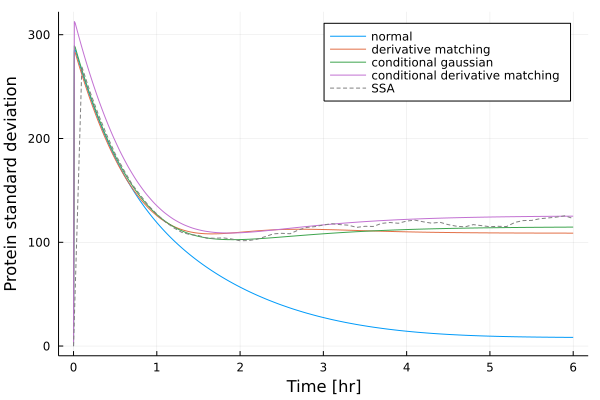

In [22]:
plot(plt_std, lw=2)

In [23]:
#savefig("../docs/src/assets/gene_1_stds.svg")

In [24]:
@parameters t, kx_on, kx_off, ky_on, ky_off, γ_x, γ_y, k_x, k_y, b_x, b_y
@variables x(t), y(t), g_x(t), g_y(t)

# g_x - gene state of X protein producing gene
# g_y - gene state of Y protein producing gene
# x, y - proteins X and Y
vars = [g_x, g_y, x, y]

# both g_x and g_y are Bernoulli random variables
binary_vars = [1, 2]

ps = [kx_on, kx_off, ky_on, ky_off, γ_x, γ_y, k_x, k_y, b_x, b_y]

# b_x and b_y denote the mean burst sizes for gene production in geometrically-distributed bursts
S = [1 -1  0  0  0    0  0    0; 
     0  0  1 -1  0    0  0    0;
     0  0  0  0  b_x -1  0    0;
     0  0  0  0  0    0  b_y -1]

as = [kx_on*(1-g_x)*y,    # 0   -> g_x
      kx_off*g_x,         # g_x -> 0
      ky_on*(1-g_y),      # 0   -> g_y
      ky_off*g_y*x,       # g_y -> 0
      k_x*g_x,            # 0   -> mx, m ~ Geometric(mean=b_x)     
      γ_x*x,              # x   -> 0
      k_y*g_y,            # 0   -> ly, l ~ Geometric(mean=b_y)
      γ_y*y]              # y   -> 0

rn = ReactionSystemMod(t, vars, ps, as, S)

# Parameter initialisation

mean_x = 100
mean_y = 100
mean_b_x = 5
mean_b_y = 5
γ_x_val = 1
γ_y_val = 1
kx_off_val = 4
ky_on_val = 0.3
kx_on_val = 0.05
ky_off_val = 0.05

k_x_val = mean_x * γ_x_val * (kx_off_val * mean_y^2 + kx_on_val) / (kx_on_val * mean_b_x)
k_y_val = mean_y * γ_y_val * (ky_off_val * mean_x^2 + ky_on_val) / (ky_on_val * mean_b_y)

# unclear if Soltani et al. (2015) actually used this parameter set as X numbers jump to millions
# making SSA extremely slow...

# introduce additional rescaling (otherwise rate coefficients are too high)
k_x_val *= 0.00003
k_y_val *= 0.01

# parameter mapping
pmap = [kx_on => kx_on_val,
        kx_off => kx_off_val,
        ky_on => ky_on_val,
        ky_off => ky_off_val,
        k_x => k_x_val,
        k_y => k_y_val,
        γ_x => γ_x_val,
        γ_y => γ_y_val,
        b_x => mean_b_x,
        b_y => mean_b_y]

# initial gene state and protein number, order [g_x, g_y, x, y]
u₀ = [1, 1, 1, 1]

# time interval to solve on
tspan = (0., 12.0);

In [25]:
eqs = generate_raw_moment_eqs(rn, 4);

In [26]:
# can compare to results in Soltani et al. (2015)
closed_eqs = moment_closure(eqs, "derivative matching", binary_vars)
latexify(closed_eqs, :closure)

"\\begin{align*}\n\\mu{_{1130}} =& \\mu{_{0010}}^{-3} \\mu{_{0020}}^{3} \\mu{_{0030}}^{-1} \\mu{_{0100}}^{-1} \\mu{_{0110}}^{3} \\mu{_{0120}}^{-3} \\mu{_{1000}}^{-1} \\mu{_{1010}}^{3} \\mu{_{1020}}^{-3} \\mu{_{1110}}^{-3} \\mu{_{1120}}^{3} \\mu{_{0130}} \\mu{_{1030}} \\mu{_{1100}} \\\\\n\\mu" ⋯ 2633 bytes ⋯ "22}} \\\\\n\\mu{_{0113}} =& \\mu{_{0001}}^{-3} \\mu{_{0002}}^{3} \\mu{_{0003}}^{-1} \\mu{_{0010}}^{-1} \\mu{_{0011}}^{3} \\mu{_{0012}}^{-3} \\mu{_{0100}}^{-1} \\mu{_{0101}}^{3} \\mu{_{0102}}^{-3} \\mu{_{0111}}^{-3} \\mu{_{0112}}^{3} \\mu{_{0013}} \\mu{_{0103}} \\mu{_{0110}}\n\\end{align*}\n"

In [27]:
closed_eqs = moment_closure(eqs, "normal", binary_vars)
latexify(closed_eqs, :closure); # very long

In [28]:
closed_eqs = moment_closure(eqs, "conditional gaussian", binary_vars)
latexify(closed_eqs, :closure)

"\\begin{align*}\n\\mu{_{1130}} =& \\mu{_{1000}}^{-1} \\mu{_{1030}} \\mu{_{1100}} + 3 \\mu{_{1000}}^{-1} \\mu{_{1020}} \\mu{_{1110}} + 6 \\mu{_{1000}}^{-3} \\mu{_{1010}}^{3} \\mu{_{1100}} + 3 \\mu{_{1000}}^{-1} \\mu{_{1010}} \\mu{_{1120}} - 6 \\mu{_{1000}}^{-2} \\mu{_{1010}}^{2} \\mu{_{11" ⋯ 3411 bytes ⋯ "\\mu{_{0100}}^{-3} \\mu{_{0101}}^{3} \\mu{_{0110}} + 3 \\mu{_{0100}}^{-1} \\mu{_{0102}} \\mu{_{0111}} + 3 \\mu{_{0100}}^{-1} \\mu{_{0101}} \\mu{_{0112}} - 6 \\mu{_{0100}}^{-2} \\mu{_{0101}}^{2} \\mu{_{0111}} - 6 \\mu{_{0100}}^{-2} \\mu{_{0101}} \\mu{_{0102}} \\mu{_{0110}}\n\\end{align*}\n"

In [29]:
closed_eqs = moment_closure(eqs, "conditional derivative matching", binary_vars)
latexify(closed_eqs, :closure)

"\\begin{align*}\n\\mu{_{1130}} =& \\mu{_{1000}}^{-1} \\mu{_{1010}}^{3} \\mu{_{1020}}^{-3} \\mu{_{1110}}^{-3} \\mu{_{1120}}^{3} \\mu{_{1030}} \\mu{_{1100}} \\\\\n\\mu{_{1121}} =& \\mu{_{1101}}^{-1} \\mu{_{1110}}^{-2} \\mu{_{1111}}^{2} \\mu{_{1100}} \\mu{_{1120}} \\\\\n\\mu{_{1112}} =& \\mu{_{11" ⋯ 1107 bytes ⋯ "} \\mu{_{0101}}^{2} \\mu{_{0102}}^{-1} \\mu{_{0110}}^{2} \\mu{_{0111}}^{-4} \\mu{_{0112}}^{2} \\mu{_{0120}}^{-1} \\mu{_{0121}}^{2} \\\\\n\\mu{_{0113}} =& \\mu{_{0100}}^{-1} \\mu{_{0101}}^{3} \\mu{_{0102}}^{-3} \\mu{_{0111}}^{-3} \\mu{_{0112}}^{3} \\mu{_{0103}} \\mu{_{0110}}\n\\end{align*}\n"

In [30]:
closed_eqs.odes.states

SymbolicUtils.Term{Real, Base.ImmutableDict{DataType, Any}}[μ₁₀₀₀(t), μ₀₁₀₀(t), μ₀₀₁₀(t), μ₀₀₀₁(t), μ₁₁₀₀(t), μ₁₀₁₀(t), μ₁₀₀₁(t), μ₀₁₁₀(t), μ₀₁₀₁(t), μ₀₀₂₀(t)  …  μ₁₀₀₃(t), μ₀₁₃₀(t), μ₀₁₂₁(t), μ₀₁₁₂(t), μ₀₁₀₃(t), μ₀₀₄₀(t), μ₀₀₃₁(t), μ₀₀₂₂(t), μ₀₀₁₃(t), μ₀₀₀₄(t)][Base.OneTo(40)]

In [31]:
using Sundials # for CVODE_BDF

closed_eqs = moment_closure(eqs, "normal", binary_vars)
u₀map = deterministic_IC(u₀, closed_eqs)

oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
sol = solve(oprob, CVODE_BDF(), saveat=0.1);


[CVODES WARNING]  CVode
  Internal t = 3.56692 and h = 1.84496e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56692 and h = 1.84496e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56692 and h = 1.84496e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56692 and h = 1.84496e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56692 and h = 1.84496e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56692 and h = 1.84496e-16 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56692 and h = 1.84496e-16 are such that t + h = t on the next step. The solver will continue a

In [32]:
closed_eqs = moment_closure(eqs, "conditional gaussian", binary_vars)
u₀map = deterministic_IC(u₀, closed_eqs)

oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
sol = solve(oprob, CVODE_BDF(), saveat=0.1);


[CVODES WARNING]  CVode
  Internal t = 1.12586 and h = 7.91963e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.12586 and h = 5.74599e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.12586 and h = 4.18103e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.12586 and h = 4.18103e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.12586 and h = 2.4457e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.12586 and h = 1.64344e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.12586 and h = 1.20635e-17 are such that t + h = t on the next step. The solver will continue an

In [35]:
dprob = DiscreteProblem(u₀, tspan, pmap)
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false, false))

ensembleprob  = EnsembleProblem(jprob)
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=0.1, trajectories=20000)
means_ssa, vars_ssa = timeseries_steps_meanvar(sol_SSA);

416.811513 seconds (3.42 G allocations: 152.831 GiB, 25.23% gc time, 0.30% compilation time)


In [36]:
plt_m = plot()   # plot mean activator protein number
plt_std = plot() # plot ssd of activator protein number

for closure in ["derivative matching", "conditional derivative matching"]

    closed_eqs = moment_closure(eqs, closure, binary_vars)

    u₀map = deterministic_IC(u₀, closed_eqs)
    oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
    sol = solve(oprob, Tsit5(), saveat=0.1)

    # μ₀₀₀₁ is the 4th and μ₀₀₀₂ is the 12th element in sol (can check with closed_eqs.odes.states)
    plt_m = plot!(plt_m, sol, vars=(0, 4), label=closure)
    plt_std = plot!(plt_std, sol.t, sqrt.(sol[12, :] .- sol[4, :].^2), label=closure)
end

plt_m = plot!(plt_m, xlabel="Time [hr]", ylabel="Activator mean level")
plt_m = plot!(plt_m, means_ssa.t, means_ssa[4,:], label="SSA", linestyle=:dash, color="gray")
plt_std = plot!(plt_std, xlabel="Time [hr]", ylabel="Activator standard deviation")
plt_std = plot!(plt_std, vars_ssa.t, sqrt.(vars_ssa[4,:]), label="SSA", linestyle=:dash, color="gray");

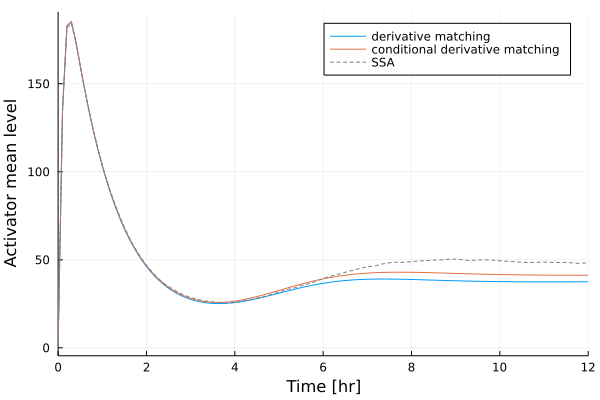

In [37]:
plot(plt_m, lw=2)

In [38]:
#savefig("../docs/src/assets/gene_2_means.svg")

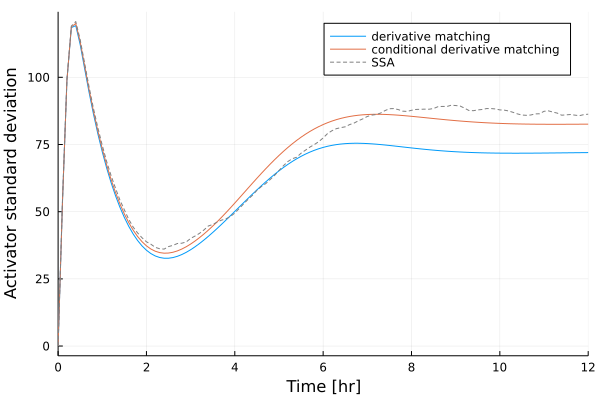

In [39]:
plot(plt_std, lw=2, xlims=(0., 12.))

In [40]:
#savefig("../docs/src/assets/gene_2_stds.svg")